In [215]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import scipy.io
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import sklearn.datasets
import re
import seaborn as sns
import datetime as dt

from tensorflow.python.framework import ops
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#from DNN_utils import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data Preprocessing

In [216]:
rawdata = pd.read_excel('SBA_Loan_data_.xlsx')

In [217]:
rawdata.head()

,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,CDC_Name,CDC_Street,CDC_City,CDC_State,...,InitialInterestRate,TermInMonths,NaicsCode,NaicsDescription,ProjectCounty,ProjectState,BusinessType,LoanStatus,ChargeOffDate,GrossChargeOffAmount
0,504,ROBERT G. FIELDS AND MARY D. F,55 & RICHLAND,KANSAS CITY,KS,66106,Avenue Area Incorporated,3324 Emerald Lane,Jefferson City,MO,...,NaN,12,NaN,NaN,WYANDOTTE,KS,INDIVIDUAL,PIF,NaT,0.0
1,504,CANDLELAMP COMPANY,3454 NIKI WAY,RIVERSIDE,CA,92507,CDC Small Business Finance Cor,2448 Historic Decatur,San Diego,CA,...,NaN,240,NaN,NaN,RIVERSIDE,CA,INDIVIDUAL,PIF,NaT,0.0
2,504,"NATIONAL COMPOSITES, INC.",2303 N. BENDIX DRIVE,SOUTH BEND,IN,46628,Business Development Corporati,218 W. Washington Street,South Bend,IN,...,NaN,120,NaN,NaN,ST JOSEPH,IN,CORPORATION,PIF,NaT,0.0
3,504,WENDY'S OF HARRISBURG,OUTLOT A. TR. 45N & SMALL ST,HARRISBURG,IL,62946,Small Business Growth Corporat,2401 West White Oaks Drive,Springfield,IL,...,NaN,240,NaN,NaN,SALINE,IL,CORPORATION,CHGOFF,2003-03-28,0.0
4,504,"RON SAUNORIS GARDEN CTR, INC.",13747 W. 159TH ST.,LOCKPORT,IL,60441,MISSNG/INACTV LENDER,NaN,NaN,NaN,...,NaN,240,NaN,NaN,WILL,IL,CORPORATION,CANCLD,NaT,0.0


In [218]:
rawdata.columns

Index(['Program', 'BorrName', 'BorrStreet', 'BorrCity', 'BorrState', 'BorrZip',
       'CDC_Name', 'CDC_Street', 'CDC_City', 'CDC_State', 'CDC_Zip',
       'ThirdPartyLender_Name', 'ThirdPartyLender_City',
       'ThirdPartyLender_State', 'ThirdPartyDollars', 'GrossApproval',
       'ApprovalDate', 'ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc',
       'InitialInterestRate', 'TermInMonths', 'NaicsCode', 'NaicsDescription',
       'ProjectCounty', 'ProjectState', 'BusinessType', 'LoanStatus',
       'ChargeOffDate', 'GrossChargeOffAmount'],
      dtype='object')

In [219]:
# drop the first column
print(np.unique(rawdata['Program']))
#checkCol(rawdata, 'Program', numRow, isCata = False)
rawdata = rawdata.drop(['Program'],axis = 1)

[504]


In [220]:
# remove cancelled and exempt
rawdata = rawdata[(rawdata['LoanStatus'] == 'PIF') | (rawdata['LoanStatus'] == 'CHGOFF')]
rawdata['target'] = [int(i) for i in rawdata['LoanStatus'] == 'CHGOFF']
rawdata.head()

,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,CDC_Name,CDC_Street,CDC_City,CDC_State,CDC_Zip,...,TermInMonths,NaicsCode,NaicsDescription,ProjectCounty,ProjectState,BusinessType,LoanStatus,ChargeOffDate,GrossChargeOffAmount,target
0,ROBERT G. FIELDS AND MARY D. F,55 & RICHLAND,KANSAS CITY,KS,66106,Avenue Area Incorporated,3324 Emerald Lane,Jefferson City,MO,65109.0,...,12,NaN,NaN,WYANDOTTE,KS,INDIVIDUAL,PIF,NaT,0.0,0
1,CANDLELAMP COMPANY,3454 NIKI WAY,RIVERSIDE,CA,92507,CDC Small Business Finance Cor,2448 Historic Decatur,San Diego,CA,92106.0,...,240,NaN,NaN,RIVERSIDE,CA,INDIVIDUAL,PIF,NaT,0.0,0
2,"NATIONAL COMPOSITES, INC.",2303 N. BENDIX DRIVE,SOUTH BEND,IN,46628,Business Development Corporati,218 W. Washington Street,South Bend,IN,46601.0,...,120,NaN,NaN,ST JOSEPH,IN,CORPORATION,PIF,NaT,0.0,0
3,WENDY'S OF HARRISBURG,OUTLOT A. TR. 45N & SMALL ST,HARRISBURG,IL,62946,Small Business Growth Corporat,2401 West White Oaks Drive,Springfield,IL,62704.0,...,240,NaN,NaN,SALINE,IL,CORPORATION,CHGOFF,2003-03-28,0.0,1
6,"ROCKY MTN EMPLOYE BENEFTS, INC",3200 S. 700 E.,SALT LAKE CITY,UT,84106,Mountain West Small Business F,2595 East 3300 South,Salt Lake City,UT,84109.0,...,240,NaN,NaN,SALT LAKE,UT,CORPORATION,PIF,NaT,0.0,0


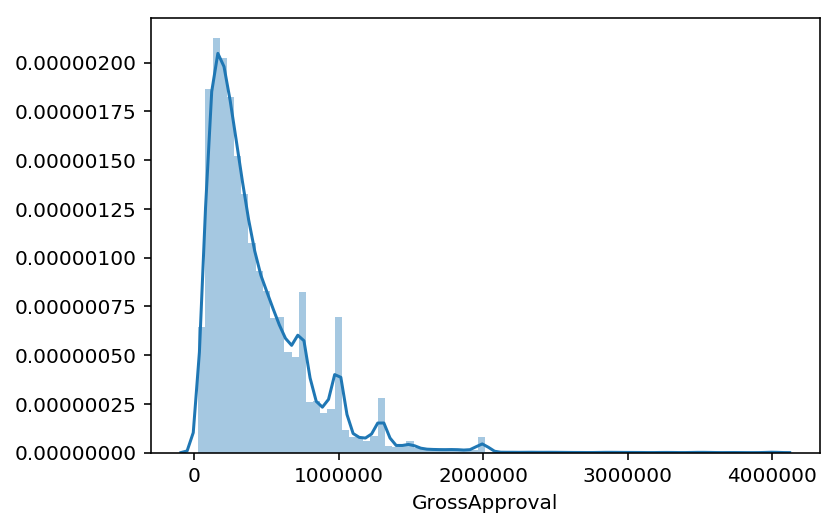

In [221]:
vis1 = sns.distplot(rawdata["GrossApproval"], bins = 80)

C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


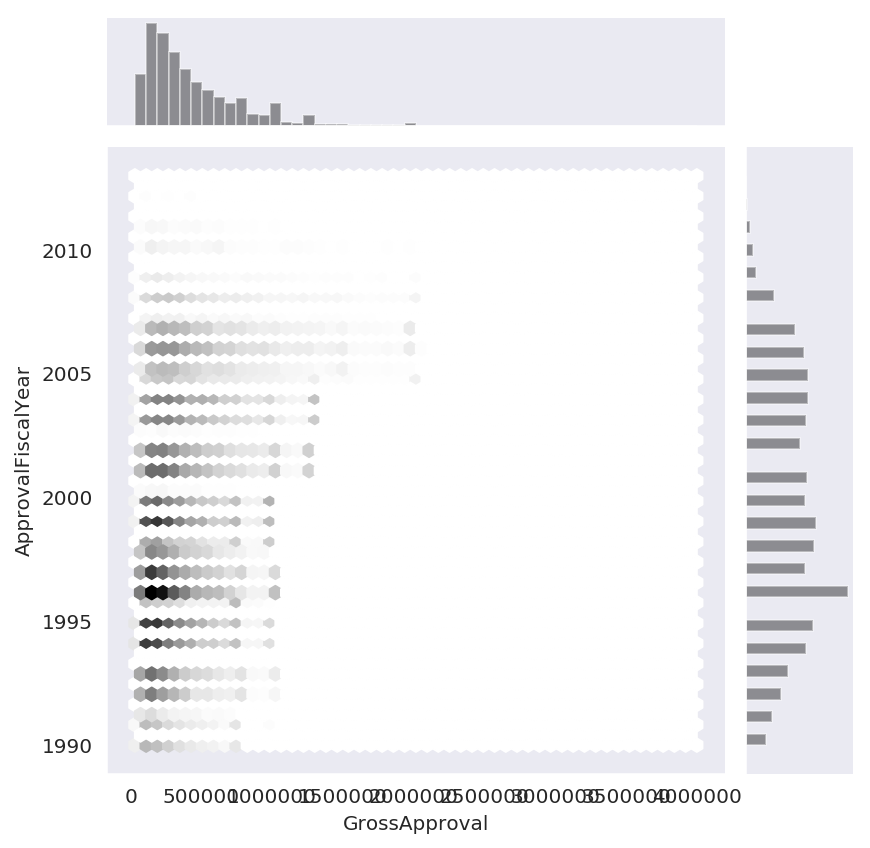

In [222]:
with sns.axes_style("dark"):
    sns.jointplot(data = rawdata, x = "GrossApproval", y = "ApprovalFiscalYear", kind="hex", color="k")

C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


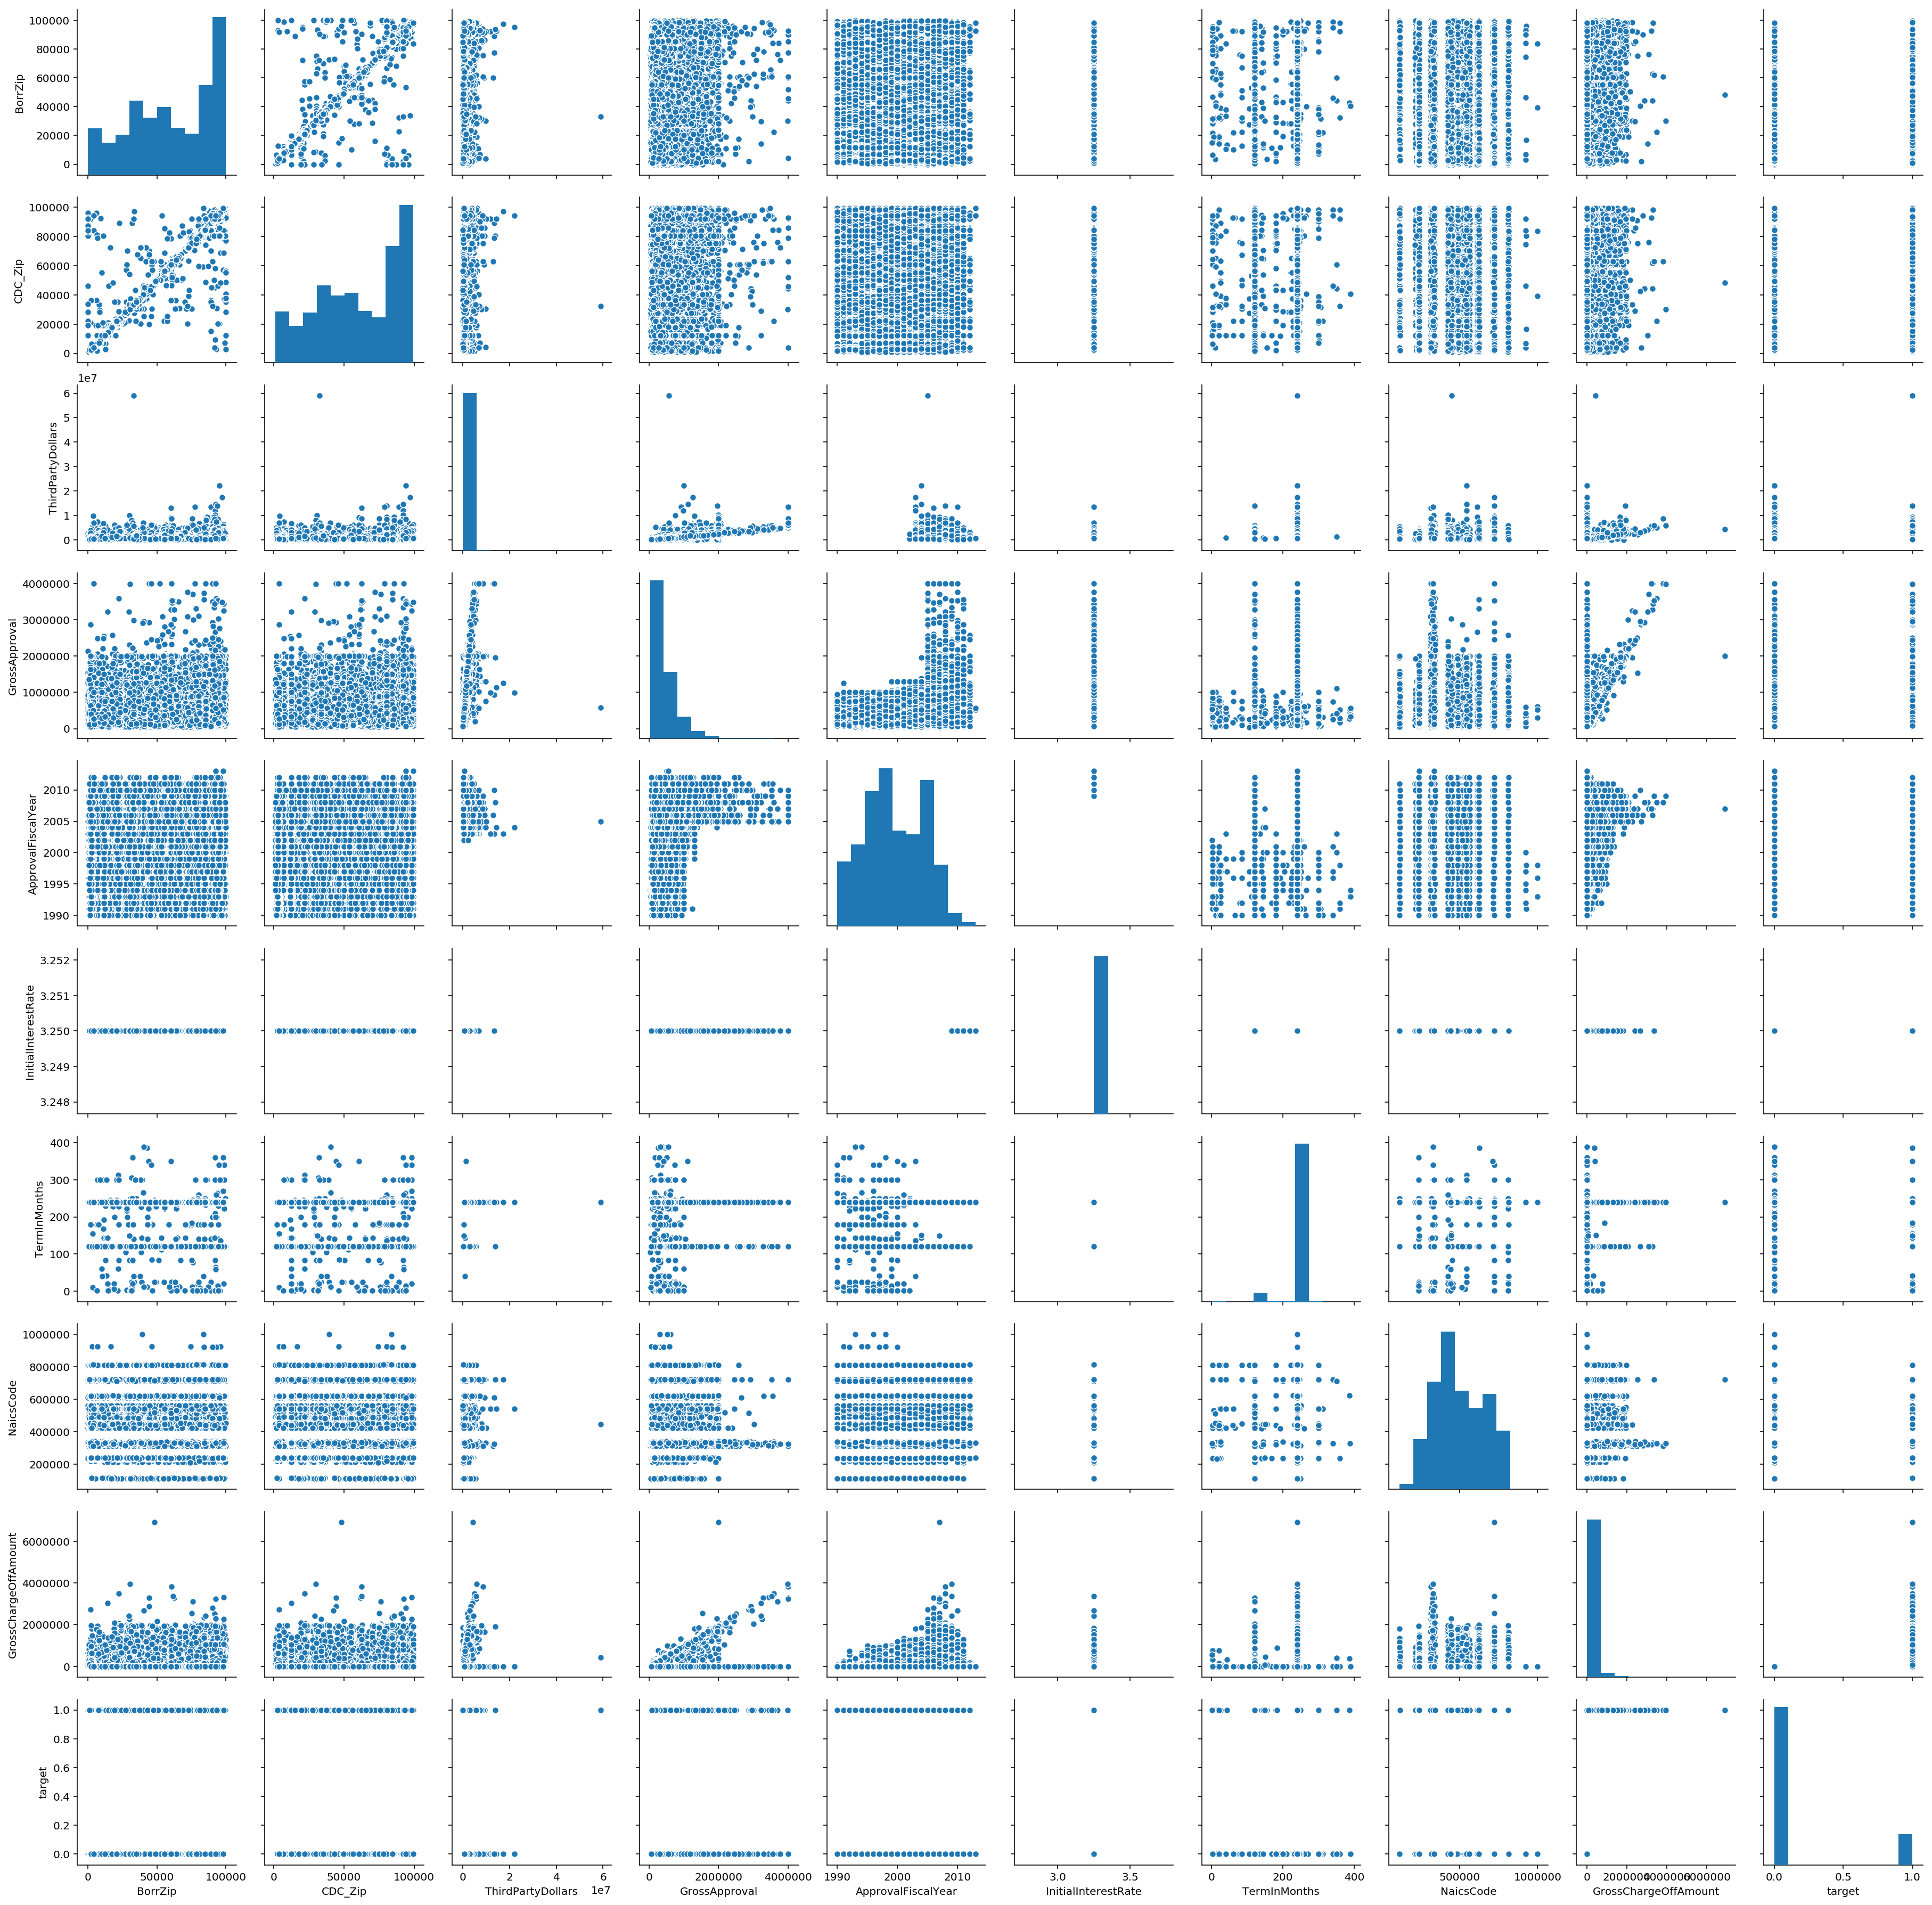

In [223]:
sns.pairplot(rawdata)

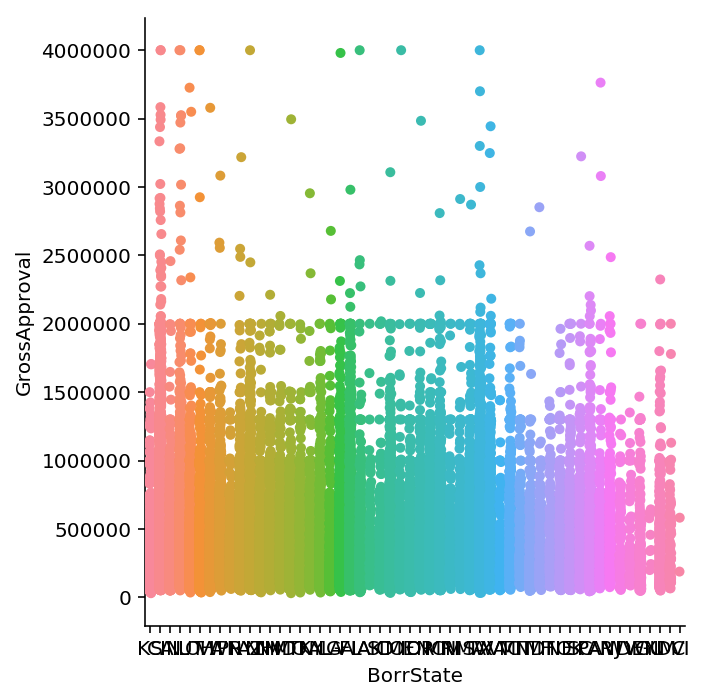

In [224]:
sns.catplot(x = "BorrState", y = "GrossApproval", data = rawdata)

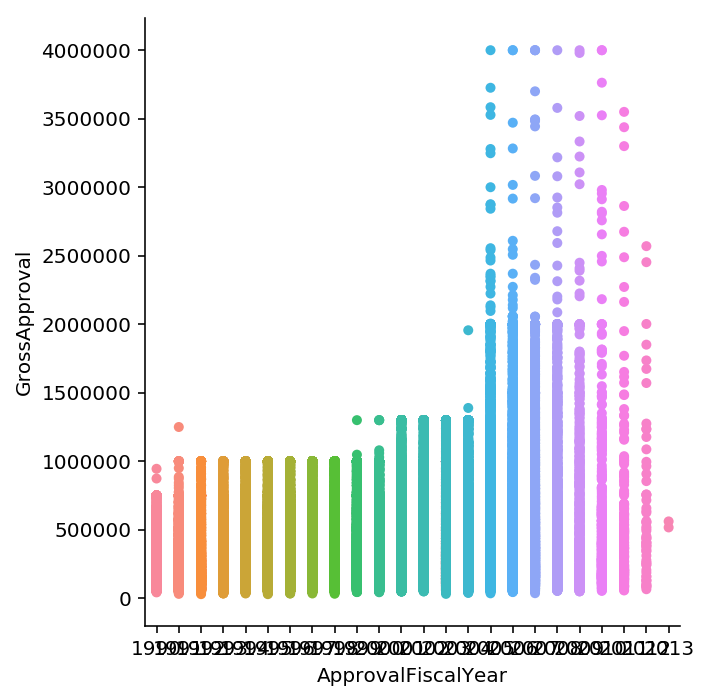

In [225]:
sns.catplot(x = "ApprovalFiscalYear", y = "GrossApproval", data = rawdata, jitter = False)

In [226]:
# add feature GSP in the borrower state and year
state = pd.read_csv('state.csv',header = None)
state.set_index(0,inplace = True)
statedict = state.to_dict()[1]
statedict['District of Columbia'] = 'DC'
statedict['Puerto Rico'] = 'PR'
statedict['Guam'] = 'GU'
gsp = pd.read_excel('GSP.xls')
gsp['state'] = gsp['GeoName'].map(lambda x: statedict[x] if x in statedict else '')
gsp.set_index('state',inplace = True)
gsp_pr = pd.read_excel('GSP-PR.xls')
gsp_pr['ind'] = gsp_pr['year'].map(lambda x: str(x)[:4])
gsp_pr.set_index('ind',inplace = True)

In [227]:
Borrgsp = []
BorrState = list(rawdata['BorrState'])
ProjectState = list(rawdata['ProjectState'])
year = list(rawdata['ApprovalFiscalYear'])
for i in range(len(year)):
    if BorrState[i] == 'PR':
        Borrgsp.append(gsp_pr.loc[str(year[i]),'GSP'])
    else:
        Borrgsp.append(gsp.loc[BorrState[i],str(year[i])] if BorrState[i] in gsp.index else 0)
rawdata['Borrgsp'] = Borrgsp

In [228]:
# add feature unemployment rate in the borrower state and year & project state and year
import re
unemploydict = {}
with open('unemply_dict.txt') as file:
    lines = file.readlines()

for i in range(len(lines)):
    if i%2 == 0:
        line = lines[i]
        state = re.search('(wide )(.+)(Season)',line).group(2)
        state = state[:(len(state)//2)][:-1]
        unemploydict[re.search('LASST(\w+)',line).group(0)] = state
#print(unemploydict)       

In [229]:
unemply_all = pd.read_excel('unemploy_all.xlsx')
flag = unemply_all['Series ID'].map(lambda x: x in unemploydict)
unemply_all['flag'] = flag
unemply_all = unemply_all[unemply_all['flag'] == True]
unemply_all['state'] = unemply_all['Series ID'].map(lambda x: statedict[unemploydict[x]])
unemply_all.set_index('state',inplace = True)
month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for y in range(1990,2014):
    cols = [m+'\n'+str(y) for m in month]
    unemply_all[y] = list(unemply_all.loc[:,cols].mean(axis=1))

In [230]:
#unemply_all.head()

In [231]:
unemploy_bow = []
for i in range(len(year)):
    unemploy_bow.append(unemply_all.loc[BorrState[i],year[i]] if BorrState[i] in unemply_all.index else 0)
rawdata['unemploy_bow'] = unemploy_bow

In [232]:
ProjectState = list(rawdata['ProjectState'])
unemploy_pro = []
for i in range(len(year)):
    unemploy_pro.append(unemply_all.loc[ProjectState[i],year[i]] if ProjectState[i] in unemply_all.index else 0)
rawdata['unemploy_pro'] = unemploy_pro

In [292]:
# add feature S&P 500 of approval date

SPall = pd.read_csv('SP500all.csv')
SPall['Date'] = pd.to_datetime(SPall['Date'])
SPall['Date'] = SPall['Date'].dt.strftime('%Y/%m/%d').astype('str')
rawdata['strdate'] = rawdata['ApprovalDate'].dt.strftime('%Y/%m/%d').astype('str')
date = list(rawdata['strdate'])
SPall.set_index('Date',inplace=True)
SP500 = []
for i in range(len(date)):
    if date[i] in SPall.index:
        SP500.append(SPall.loc[date[i],'Adj Close'])
    else:
        prev = date[i][:-2]+str(int(date[i][-2:])-1).zfill(2)
        if prev in SPall.index:
            SP500.append(SPall.loc[prev,'Adj Close'])
        else:
            post = date[i][:-2]+str(int(date[i][-2:])+1).zfill(2)
            if post in SPall.index:
                SP500.append(SPall.loc[post,'Adj Close'])   
            else:
                prev2 = date[i][:-2]+str(int(date[i][-2:])-2).zfill(2)
                SP500.append(SPall.loc[prev2,'Adj Close'])
rawdata['SP500'] = SP500

In [293]:
SP500

[359.690002,
 359.690002,
 358.76001,
 358.76001,
 358.76001,
 358.76001,
 358.76001,
 355.670013,
 352.200012,
 352.200012,
 352.200012,
 352.200012,
 352.200012,
 352.200012,
 353.790009,
 349.619995,
 349.619995,
 349.619995,
 349.619995,
 349.619995,
 347.309998,
 347.309998,
 347.309998,
 348.52999900000003,
 348.52999900000003,
 339.929993,
 339.929993,
 339.929993,
 339.929993,
 340.75,
 340.75,
 337.399994,
 337.399994,
 337.399994,
 337.399994,
 337.399994,
 337.399994,
 337.399994,
 337.399994,
 338.190002,
 338.190002,
 338.190002,
 338.190002,
 338.190002,
 338.190002,
 339.149994,
 339.149994,
 339.149994,
 339.149994,
 339.149994,
 339.149994,
 330.380005,
 330.380005,
 330.380005,
 330.380005,
 330.380005,
 331.609985,
 331.609985,
 331.609985,
 331.609985,
 330.26001,
 330.26001,
 330.26001,
 326.079987,
 326.079987,
 326.079987,
 326.079987,
 325.799988,
 325.799988,
 325.799988,
 325.799988,
 325.799988,
 325.799988,
 325.799988,
 325.200012,
 325.200012,
 325.200012,

In [115]:
# add feature borrower state != bank state

rawdata['borr=CDC'] = rawdata['BorrState'] == rawdata['CDC_State']

In [116]:
# add feature borrower state != third party lender state

rawdata['borr=third'] = rawdata['BorrState'] == rawdata['ThirdPartyLender_State']

In [117]:
# add feature borrower state != project state

rawdata['borr=pro'] = rawdata['BorrState'] == rawdata['ProjectState']

In [118]:
# log transformation
logcols = ['GrossApproval','ThirdPartyDollars','SP500']
for col in logcols:
    rawdata[col] = np.log(rawdata[col])
borrgsp = list(rawdata['Borrgsp'])
logborrgsp = []
for i in range(len(borrgsp)):
    if i == 0:
        logborrgsp.append(0)
    else:
        logborrgsp.append(np.log(i))

In [119]:
# add feature total loan amount

rawdata['total'] = rawdata['ThirdPartyDollars'] + rawdata['GrossApproval']

In [120]:
# add feature term is integer times of year

rawdata['termint'] = rawdata['TermInMonths']%12 == 0

In [121]:
# add feature loan age

rawdata['age'] = rawdata['ChargeOffDate'] - rawdata['ApprovalDate']
rawdata['age'] = rawdata['age'].fillna(0).astype('str')
age = rawdata['age'].map(lambda x: x.split('days')[0][:-1])
rawdata['age'] = age.astype('int64')

In [122]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54806 entries, 0 to 140496
Data columns (total 40 columns):
BorrName                  54806 non-null object
BorrStreet                54798 non-null object
BorrCity                  54806 non-null object
BorrState                 54806 non-null object
BorrZip                   54806 non-null int64
CDC_Name                  54806 non-null object
CDC_Street                54614 non-null object
CDC_City                  54614 non-null object
CDC_State                 54614 non-null object
CDC_Zip                   54614 non-null float64
ThirdPartyLender_Name     16953 non-null object
ThirdPartyLender_City     16953 non-null object
ThirdPartyLender_State    17068 non-null object
ThirdPartyDollars         16881 non-null float64
GrossApproval             54806 non-null float64
ApprovalDate              54806 non-null datetime64[ns]
ApprovalFiscalYear        54806 non-null int64
DeliveryMethod            54806 non-null object
subpgmdesc       

In [123]:
numRow = len(rawdata)
def checkCol(df, colName, numRow, isCata = True):
    print(colName, ':')
    print('Any NA?: ', df[colName].isnull().values.any())
    if df[colName].isnull().values.any():
        numNA = sum(df[colName].isnull().values)
        print ('    # of NA: ', numNA)
        print ('    NA%:     ', numNA/numRow)
    if isCata:
        levelList = df[colName].unique()
        print('Different levels: ', len(levelList), levelList)
        fillna(df, colName, isCata = True)
        
    else:
        print('range: ', min(df[colName].astype(float).dropna()), max(df[colName].astype(float).dropna()))
        fillna(df, colName, isCata = False)
        
def fillna(df, colName, isCata = True):
    if isCata:
        df[colName] = df[colName].fillna('0')
    else:
        df[colName] = df[colName].fillna(0)
    return df


In [124]:
catCols = ['BorrName', 'BorrStreet', 'BorrCity', 'BorrState','CDC_Name', 'CDC_Street', 'CDC_City', 'CDC_State', 'ThirdPartyLender_Name', 'ThirdPartyLender_City',
       'ThirdPartyLender_State', 'ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc','NaicsCode', 'NaicsDescription',
       'ProjectCounty', 'ProjectState', 'BusinessType'
       ]
numCols = ['BorrZip','CDC_Zip','ThirdPartyDollars', 'GrossApproval','InitialInterestRate', 'TermInMonths','Borrgsp','unemploy_bow','unemploy_pro','SP500','borr=third','borr=pro','borr=CDC','total','termint']
for col in catCols:
    checkCol(rawdata, col, numRow, isCata = True)
for col in numCols:
    checkCol(rawdata, col, numRow, isCata = False)

BorrName :
Any NA?:  False
Different levels:  52068 ['ROBERT G. FIELDS AND MARY D. F' 'CANDLELAMP COMPANY'
 'NATIONAL COMPOSITES, INC.' ... 'Master Precision Global, LLC'
 'Precision Electric Group, Inc.' 'Material Innovations, Incorpor']
BorrStreet :
Any NA?:  True
    # of NA:  8
    NA%:      0.0001459694194066343
Different levels:  53510 ['55 & RICHLAND' '3454 NIKI WAY' '2303 N. BENDIX DRIVE' ...
 '1212 Fairplains Street.' '7710 185th Avenue NE.' '17611 Metzler Lane.']
BorrCity :
Any NA?:  False
Different levels:  7442 ['KANSAS CITY' 'RIVERSIDE' 'SOUTH BEND' ... 'Sonoma' 'Vicksburg' 'Redmond']
BorrState :
Any NA?:  False
Different levels:  54 ['KS' 'CA' 'IN' 'IL' 'UT' 'OH' 'VA' 'WI' 'PR' 'NY' 'AZ' 'NH' 'NV' 'MD'
 'MO' 'TN' 'KY' 'AL' 'LA' 'GA' 'FL' 'IA' 'AK' 'SD' 'CO' 'ME' 'ID' 'OR'
 'NC' 'MN' 'RI' 'MS' 'MA' 'TX' 'WA' 'VT' 'MI' 'CT' 'ND' 'MT' 'HI' 'NE'
 'OK' 'SC' 'PA' 'AR' 'NJ' 'WV' 'DE' 'WY' 'GU' 'NM' 'DC' 'VI']
CDC_Name :
Any NA?:  False
Different levels:  296 ['Avenue Area Incorp

Different levels:  334 ['3324 Emerald Lane' '2448 Historic Decatur' '218 W. Washington Street'
 '2401 West White Oaks Drive' '2595 East 3300 South' '900 Michigan Avenue'
 '130 W. Second St.' '1964 Wakefield Street' '100 River Place'
 '239 Arterial Hostos Avenue' '16 James Street' '410 Hemsted Drive'
 '335 N. Wilmot Road' 'One Cate Street' '626 South 9th Street'
 '426 D Street' nan '200 W. Douglas' '441 East Whittier Boulevard'
 '300 East State Street,' '5333 South Adams Ave.' '1100 14th Street'
 '5217 Hwy. B' '111 St. James Court' '151 N. Delaware'
 '8132 Old Federal Rd.' '5210 Hollywood Avenue' '50 Beaver Street'
 '6445 Powers Ferry Road' '1100 Walnut' '6801 Lake Worth Road'
 '1500 1st Avenue North' '5409 NW 88th Street' '809 North Broadway'
 '619 Warehouse Ave' '711 E. Wells Avenue' '1175 Osage Street'
 '40 Harlow Street' '400 Robert D Ray Drive' '175-C Emory Highway'
 '7370 Liberty One Drive' '1631 17th Street' '1161 W River Street'
 '117 Southcrest Drive' '1300 Baxter Street' '1776

ThirdPartyLender_City :
Any NA?:  True
    # of NA:  37853
    NA%:      0.690672554099916
Different levels:  1582 [nan 'MIAMI' 'SALT LAKE CITY' ... 'LOS ALTOS' 'MODESTO' 'CURRIE']
ThirdPartyLender_State :
Any NA?:  True
    # of NA:  37738
    NA%:      0.6885742436959457
Different levels:  62 [nan 'FL' 'UT' 'NJ' 'CA' 'NC' 'TX' 'DE' 'NH' 'RI' 'NY' 'VA' 'CT' 'IL' 'OH'
 'MA' 'SD' 'MN' 'MO' 'WA' 'AZ' 'CO' 'GA' 'SC' 'ND' 'OR' 'NV' 'IA' 'KS'
 'AL' 'TN' 'MI' 'PA' 'NE' 'HI' 'IN' 'WV' 'PR' 'NM' 'OK' 'MT' 'MS' 'KY'
 'ID' '#N' 'MD' 'WI' 'DC' 'VT' 'ME' 'AK' 'LA' 'AR' 'Ba' '0' 'WY' 'St' 'AB'
 'BC' 'D.' 'Ro' 'GU']
ApprovalFiscalYear :
Any NA?:  False
Different levels:  24 [1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013]
DeliveryMethod :
Any NA?:  False
Different levels:  4 ['504' 'PCLP' 'ALP' '504REFI']
subpgmdesc :
Any NA?:  False
Different levels:  4 ['Sec. 504 - Loan Guarantees - Private Sector Financed'
 'Sec. 504 - Delt

In [128]:
# transform data type
rawdata['CDC_Zip'] = rawdata['CDC_Zip'].astype('int64')
for col in catCols:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(rawdata[col].values.astype('str')))
    rawdata[col] = lbl.transform(list(rawdata[col].values.astype('str')))
    rawdata[col] = rawdata[col].astype('category')
rawdata['InitialInterestRate'] = rawdata['InitialInterestRate'].astype('float64')
rawdata['ThirdPartyDollars'] = rawdata['ThirdPartyDollars'].astype('float64')
rawdata['total'] = rawdata['total'].astype('float64')
rawdata['borr=pro'] = rawdata['borr=pro'].astype('int64')
rawdata['borr=third'] = rawdata['borr=third'].astype('int64')
rawdata['borr=CDC'] = rawdata['borr=CDC'].astype('int64')
rawdata['termint'] = rawdata['termint'].astype('int64')
rawdata.dtypes

BorrName                        category
BorrStreet                      category
BorrCity                        category
BorrState                       category
BorrZip                            int64
CDC_Name                        category
CDC_Street                      category
CDC_City                        category
CDC_State                       category
CDC_Zip                            int64
ThirdPartyLender_Name           category
ThirdPartyLender_City           category
ThirdPartyLender_State          category
ThirdPartyDollars                float64
GrossApproval                    float64
ApprovalDate              datetime64[ns]
ApprovalFiscalYear              category
DeliveryMethod                  category
subpgmdesc                      category
InitialInterestRate              float64
TermInMonths                       int64
NaicsCode                       category
NaicsDescription                category
ProjectCounty                   category
ProjectState    

In [147]:
# split the data
y = list(rawdata['target'])
X = rawdata[numCols+catCols]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=1)
train_X, val_X, train_y, val_y = train_test_split(train_X,train_y,test_size=0.2,random_state=1)


## Baseline: Logistic Regression

In [148]:
# standardization and one-hot encoding
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numCols),
                                               ('cat', categorical_transformer, catCols)])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

clf.fit(train_X, train_y)
print("model score: %.3f" % clf.score(val_X, val_y))
print(classification_report(val_y, clf.predict(val_X)))
print(roc_auc_score(val_y, clf.predict_proba(val_X)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-pack

model score: 0.872
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7361
           1       0.66      0.42      0.51      1408

   micro avg       0.87      0.87      0.87      8769
   macro avg       0.78      0.69      0.72      8769
weighted avg       0.86      0.87      0.86      8769

0.8475466910992825


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.8475466910992825


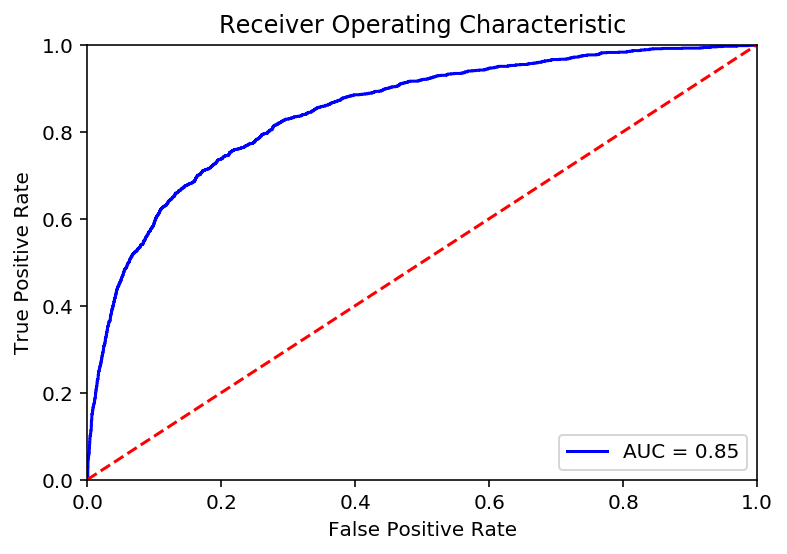

In [149]:
# ROC_AUC curve for logistic regression
probs = clf.predict_proba(val_X)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(val_y, preds)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Logistic Regression with Regularization

#### L1

In [150]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(penalty='l1'))])

clf.fit(train_X, train_y)
print("model score: %.3f" % clf.score(val_X, val_y))
print(classification_report(val_y, clf.predict(val_X)))
print(roc_auc_score(val_y, clf.predict_proba(val_X)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-pack

model score: 0.872
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7361
           1       0.66      0.41      0.51      1408

   micro avg       0.87      0.87      0.87      8769
   macro avg       0.78      0.69      0.72      8769
weighted avg       0.86      0.87      0.86      8769

0.8463871324301293


C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### L2

In [151]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(penalty='l2'))])

clf.fit(train_X, train_y)
print("model score: %.3f" % clf.score(val_X, val_y))
print(classification_report(val_y, clf.predict(val_X)))
print(roc_auc_score(val_y, clf.predict_proba(val_X)[:,1]))

C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\THINKPAD\AppData\Roaming\Python\Python36\site-pack

model score: 0.872
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7361
           1       0.66      0.42      0.51      1408

   micro avg       0.87      0.87      0.87      8769
   macro avg       0.78      0.69      0.72      8769
weighted avg       0.86      0.87      0.86      8769

0.8475466910992825


## Tree Models

### Gradient Boosting

In [152]:
def run_lgbc(train_X, train_y, val_X, val_y):
    params = {
        "objective" : "binary",
        "metric" : "binary_logloss", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)

    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return model, pred_val_y


In [153]:
modelC, pred_val_y = run_lgbc(train_X, train_y, val_X, val_y)
print(classification_report(val_y, modelC.predict(val_X)>0.5))
print(roc_auc_score(val_y, modelC.predict(val_X)))

C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.32319
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.312595
              precision    recall  f1-score   support

           0       0.89      0.96      0.93      7361
           1       0.68      0.40      0.50      1408

   micro avg       0.87      0.87      0.87      8769
   macro avg       0.79      0.68      0.71      8769
weighted avg       0.86      0.87      0.86      8769

0.852814394968569


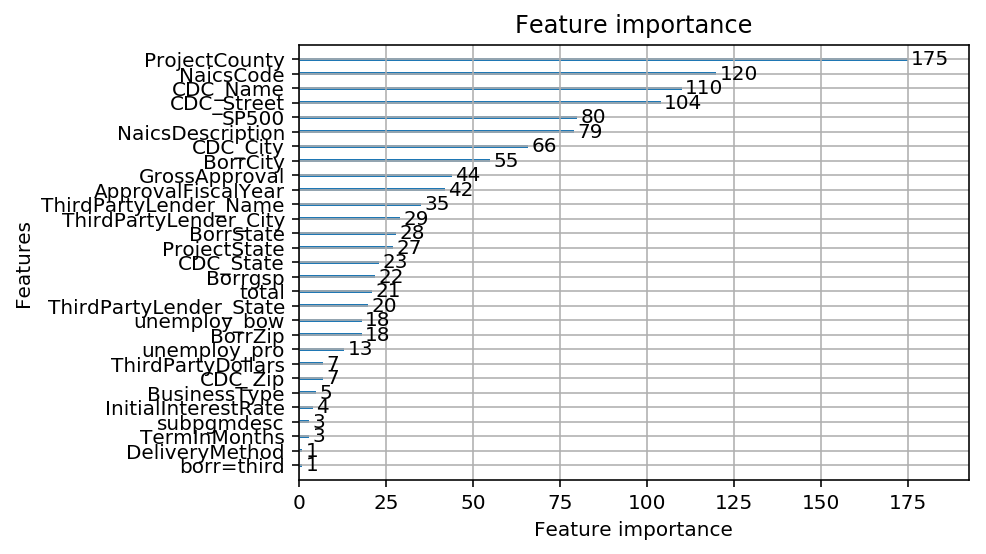

In [154]:
lgb.plot_importance(modelC)

#### Oversampling

##### 1. Random Oversampling

In [175]:
ros = RandomOverSampler(random_state=0, sampling_strategy = 0.3)
X_resampled, y_resampled = ros.fit_resample(train_X, train_y)
#X_resampled = pd.DataFrame(X_resampled, columns=train_X.columns)


In [176]:
modelC, pred_val_y = run_lgbc(X_resampled, y_resampled, val_X, val_y)
print(classification_report(val_y, modelC.predict(val_X)>0.5))
print(roc_auc_score(val_y, modelC.predict(val_X)))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.316449
[200]	valid_0's binary_logloss: 0.314093
[300]	valid_0's binary_logloss: 0.314576
Early stopping, best iteration is:
[209]	valid_0's binary_logloss: 0.313893
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      7361
           1       0.63      0.51      0.56      1408

   micro avg       0.87      0.87      0.87      8769
   macro avg       0.77      0.73      0.75      8769
weighted avg       0.86      0.87      0.87      8769

0.8577258756221363


##### 2. SMOTE

In [188]:
sm = SMOTE(random_state=0, sampling_strategy = 0.3)
X_smote, y_smote = sm.fit_resample(train_X, train_y)
#print('Original dataset shape %s' % Counter(train_y))
#print('SMOTE dataset shape %s' % Counter(y_smote))

In [189]:
modelC, pred_val_y = run_lgbc(X_smote, y_smote, val_X, val_y)
print(classification_report(val_y, modelC.predict(val_X)>0.5))
print(roc_auc_score(val_y, modelC.predict(val_X)))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.313906
[200]	valid_0's binary_logloss: 0.314102
Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.312691
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      7361
           1       0.68      0.44      0.53      1408

   micro avg       0.88      0.88      0.88      8769
   macro avg       0.79      0.70      0.73      8769
weighted avg       0.86      0.88      0.87      8769

0.853484484414173


### Random Forest

## DNN

C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\THINKPAD\AppData\Local\Continuum\Anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


Cost after epoch 0: 17504.457699
Cost after epoch 100: 109.061628
Cost after epoch 200: 93.162514
Cost after epoch 300: 90.435052
Cost after epoch 400: 67.341103


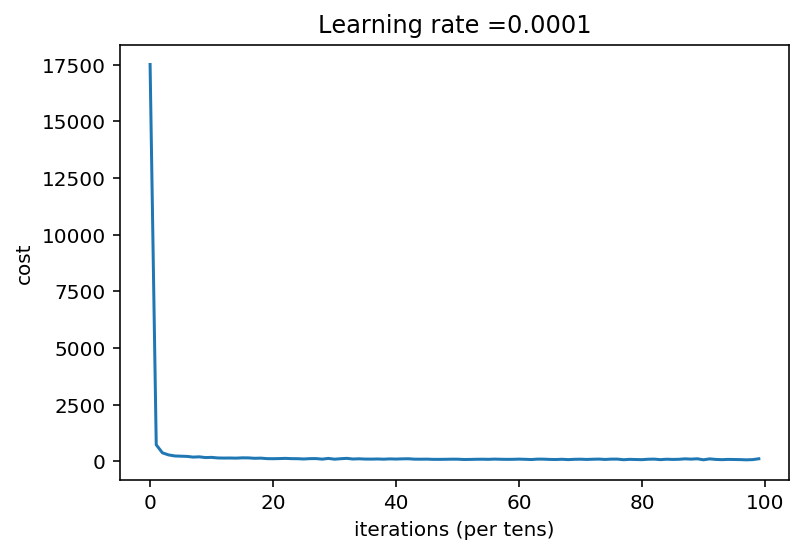

Parameters have been trained!
Train Accuracy: 0.8087812
Test Accuracy: 0.8065914


In [175]:
%run DNN_utils.py
#read your data in, remeber to use one_hot_encoding for your Y, otherwise TF will not work
DNNtrain_X = train_X.T.as_matrix()
DNNval_X = val_X.T.as_matrix()
DNNtrain_y = np.array(train_y).reshape(1,-1)
DNNval_y = np.array(val_y).reshape(1,-1)
DNNtrain_y = convert_to_one_hot(DNNtrain_y, 2)
DNNval_y = convert_to_one_hot(DNNval_y, 2)

# cross validation
learning_rates = [0.00001,0.0001,0.01,0.1]
params_all = [[100,50,2],[128,64,2],[64,32,2],[256,128,2],[256,64,2],[512,256,2],[512,128,2]]
keep_probs = [1,0.9,0.8]
lambs = [0.01,0.1,1]
minibatch_sizes = [256,512,1024]

aucl = []
for l in learning_rates:
    print('choose learning rate')
    print(l)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,learning_rate=l)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    aucl.append(auc)
    print(auc)
    print('----------------------------')
maxaucl = max(aucl)
bestl = learning_rates[aucl.index(maxaucl)]
print('Best learning rate: {}'.format(bestl))
print('Best AUC: {}'.format(maxaucl))

auck = []
for k in keep_probs:
    print('choose dropout prob')
    print(k)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,learning_rate = bestl, keep_prob = k)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    auck.append(auc)    
    print(auc)
    print('----------------------------')
maxauck = max(auck)
bestk = keep_probs[auck.index(maxauck)]
print('Best dropout prob: {}'.format(bestk))
print('Best AUC: {}'.format(maxauck))


aucp = []
for p in params_all:
    print('choose # nodes')
    print(p)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,learning_rate = bestl, params = p, keep_prob = bestk)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    aucp.append(auc)    
    print(auc)
    print('----------------------------')    
maxaucp = max(aucp)
bestp = params_all[aucp.index(maxaucp)]
print('Best # nodes: {}'.format(bestp))
print('Best AUC: {}'.format(maxaucp))


aucla = []    
for la in lambs:
    print('choose regularization param')
    print(la)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,learning_rate = bestl, params = bestp, keep_prob = bestk, lamb = la)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    aucla.append(auc)    
    print(auc)
    print('----------------------------')
maxaucla = max(aucla)
bestla = lambs[aucla.index(maxaucla)]
print('Best regularization param: {}'.format(bestla))
print('Best AUC: {}'.format(maxaucla))

aucmi = []
for mi in minibatch_sizes:
    print('choose minibatch size')
    print(mi)
    parameters = model(DNNtrain_X, DNNtrain_y, DNNval_X, DNNval_y,learning_rate = bestl, params = bestp, keep_prob = bestk, lamb = bestla,minibatch_size = mi)
    default_prob = get_probability(parameters, DNNval_X)[1,:]
    auc = roc_auc_score(DNNval_y[1,:], default_prob)
    aucmi.append(auc)  
    print(auc)
    print('----------------------------')
maxaucmi = max(aucmi)
bestmi = minibatch_sizes[aucmi.index(maxaucmi)]
print('Best minibatch sizes: {}'.format(bestmi))
print('Best AUC: {}'.format(maxaucmi))

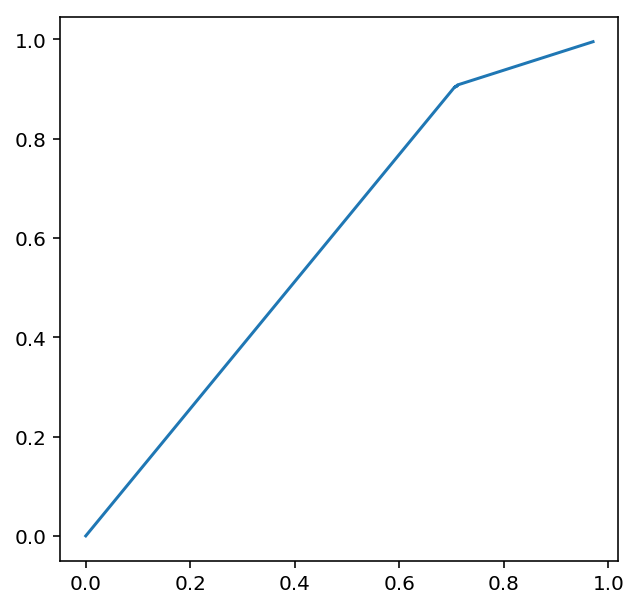

In [202]:
default_prob = get_probability(parameters, DNNval_X)[1,:]
n = 200
TPR = np.zeros((n,1))
FPR = np.zeros((n,1))
t = np.linspace(0.0, 1.0, n)
for i in range(n):
    TPR[i,0], FPR[i,0] = get_ROC(default_prob,t[i],DNNval_y[1,:])
plt.figure(figsize=(5,5))
plt.plot(FPR, TPR)

In [204]:
roc_auc_score(DNNval_y[1,:], default_prob)

0.6163920763297972

## Regression

### Linear Regression

### Lasso

### Ridge

### Gradient Boosting

### DNN